In [1]:
%reload_ext autoreload
%autoreload 2
# %autoreload 1
# %aimport from kret_studies import *
# %aimport from kret_studies.notebook_imports import *
# %load_ext fireducks.pandas # linux only for now

In [2]:
from kret_studies import *
from kret_studies.notebook import *
from kret_studies.complex import *

logger = get_notebook_logger()

Loaded environment variables from /Users/Akseldkw/Desktop/Columbia/ORCS4529/.env.
/Users/Akseldkw/coding/kretsinger/data/nb_log.log


In [3]:
gamma = 0.5
actions = (0.0, 0.5, 1.0)
states = (1, 2)


def reward(s: t.Literal[1, 2], action: float) -> float:
    if s == 1:
        return -action

    return (action / 12) - 1


def transition(s: t.Literal[1, 2], action: float) -> t.Tuple[float, float]:
    if s == 1:
        p_stay = action**2 / 2
        return p_stay, 1 - p_stay

    p_stay = action**2 / 4
    return p_stay, 1 - p_stay

## Quick Heuristic Visualization

In [ ]:
rewards = pd.DataFrame(
    index=states,
    columns=actions,
    data=[[reward(s, a) for a in actions] for s in states],
).round(3)
transitions = {
    s: pd.DataFrame(
        index=states,
        columns=actions,
        data=[[transition(s, a)[i] for a in actions] for i in range(len(states))],
    )
    for s in states
}
rewards.index.name = "State"
rewards.columns.name = "Action"
# rewards.title = "Reward Table"

for s in transitions:
    transitions[s].index.name = "Next State"
    transitions[s].columns.name = "Action"
    # transitions[s].title = f"Transition Probabilities (from state {s})"

In [23]:
# fig, ax = uks_mpl.subplots(1, 1, 3, 3)
# uks_mpl.heatmap_df(rewards, ax=ax)
# fig.suptitle("Reward Table")
# fig

{'annot': True, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x30adfab40>, 'linewidths': 0.1, 'cbar': True, 'vmin': -1.0, 'vmax': 0, 'fmt': '.2f', 'ax': <Axes: >}
{'annot': True, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x30ade2000>, 'linewidths': 0.1, 'cbar': True, 'vmin': 0, 'vmax': 1.0, 'fmt': '.2f', 'ax': <Axes: >}
{'annot': True, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x30ade2000>, 'linewidths': 0.1, 'cbar': True, 'vmin': 0, 'vmax': 1.0, 'fmt': '.2f', 'ax': <Axes: >}


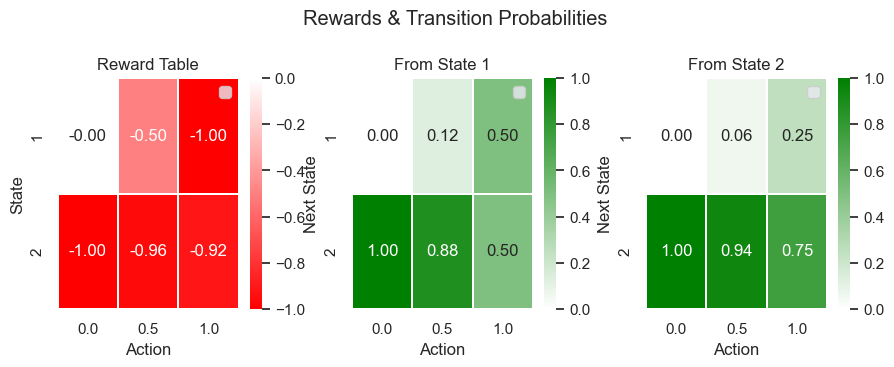

In [38]:
fig, ax = uks_mpl.subplots(3, 1, 3, 3)
fig.subplots_adjust(wspace=0.3)
fig.suptitle("Rewards & Transition Probabilities", y=1.15)

uks_mpl.heatmap_df(rewards, ax=ax[0])
ax[0].set_title("Reward Table")
uks_mpl.heatmap_df(transitions[1], ax=ax[1])
ax[1].set_title("From State 1")
uks_mpl.heatmap_df(transitions[2], ax=ax[2])
ax[2].set_title("From State 2")
fig

In [ ]:
display(Markdown("### Transitions (from state 1)"))
display(transitions[1])

In [ ]:
display(Markdown("### Transitions (from state 2)"))
display(transitions[2])

In [ ]:
def bellman_update(v: np.ndarray, s: t.Literal[1, 2]) -> float:
    """
    Perform a Bellman update for state s given value function v.
    """
    action_values = [
        reward(s, a) + gamma * sum(transition(s, a)[i] * v[i] for i in range(2))
        for a in actions
    ]
    best_action = actions[np.argmax(action_values)]
    assert best_action in actions
    return max(action_values)


def policy_update(v: np.ndarray, s: t.Literal[1, 2]) -> float:
    """
    Perform a policy update for state s given value function v.
    """
    action_values = [
        reward(s, a) + gamma * sum(transition(s, a)[i] * v[i] for i in range(2))
        for a in actions
    ]
    best_action = actions[np.argmax(action_values)]
    assert best_action in actions
    # pi[s - 1] = best_action
    return best_action

: 

: 

In [ ]:
def value_iteration(
    v_init: np.ndarray | None, max_iterations: int | None = None, print_first_k: int = 4
) -> np.ndarray:
    """
    Perform value iteration until convergence.
    """
    v = np.zeros(2) if v_init is None else v_init.copy()
    k = 0
    max_iter = 1000 if max_iterations is None else max_iterations
    while True:
        new_v = np.array([bellman_update(v, s) for s in states])
        if k < print_first_k:
            print(f"Iter {k+1}: V = {new_v}")
        if np.max(np.abs(new_v - v)) < 1e-6:
            break
        v = new_v
        k += 1
        if max_iter != -1 and k >= max_iter:
            print(f"Stopped after reaching max_iter={max_iter}")
            break
    print(f"Converged after {k+1} iterations.")
    return v


def policy_iteration(
    v_init: np.ndarray | None, max_iterations: int | None = None, print_first_k: int = 4
) -> t.Tuple[np.ndarray, np.ndarray]:
    """
    Perform policy iteration until convergence.
    """
    v = np.zeros(2) if v_init is None else v_init.copy()
    pi = np.array([0.0, 0.0])
    k = 0
    max_iter = 1000 if max_iterations is None else max_iterations
    while True:
        new_v = np.array([bellman_update(v, s) for s in states])
        new_pi = np.array([policy_update(new_v, s) for s in states])
        if k < print_first_k:
            print(f"Iter {k+1}: V = {new_v}, pi = {new_pi}")
        if np.max(np.abs(new_v - v)) < 1e-6 and np.all(new_pi == pi):
            break
        v = new_v
        pi = new_pi
        k += 1
        if max_iter != -1 and k >= max_iter:
            print(f"Stopped after reaching max_iter={max_iter}")
            break
    print(f"Converged after {k+1} iterations.")
    return v, pi

: 

: 

In [ ]:
values = value_iteration(None)
print("Optimal values:", values)

Iter 1: V = [ 0.         -0.91666667]
Iter 2: V = [-0.45833333 -1.26041667]
Iter 3: V = [-0.63020833 -1.44661458]
Iter 4: V = [-0.72330729 -1.53792318]
Converged after 21 iterations.
Optimal values: [-0.81481342 -1.62962823]


: 

: 

In [ ]:
policies = policy_iteration(None)
print("Optimal policies:", policies)

Iter 1: V = [ 0.         -0.91666667], pi = [0. 1.]
Iter 2: V = [-0.45833333 -1.26041667], pi = [0. 1.]
Iter 3: V = [-0.63020833 -1.44661458], pi = [0. 1.]
Iter 4: V = [-0.72330729 -1.53792318], pi = [0. 1.]
Converged after 21 iterations.
Optimal policies: (array([-0.81481342, -1.62962823]), array([0., 1.]))


: 

: 

: 

: 

: 

: 